# Data Preprocessing

In [1]:
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import os
data_path = '/home/jovyan'
filename = 'spotify_audio_feature.csv'
path_to_data = os.path.join(data_path, filename)

In [5]:
df = pd.read_csv(path_to_data)

In [6]:
df.head()

,track_id,artists_id,album_id,track_name,artists_name,album_name,album_type,release_date,release_date_precision,is_explicit,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_follower
0,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,04G0YylSjvDQZrjOfE5jA5,I'm Yours,Jason Mraz,We Sing. We Dance. We Steal Things.,album,2008-05-12,day,False,85,acoustic,0.686,0.457,11,-8.322,1,0.0468,0.595,0.0,0.1050,0.718,150.953,242187,4,4174839
1,5vjLSffimiIP26QG5WcN2K,5D3muNJhYYunbRkh3FKgX0,2EfmyRWheMtmVTCIsptsLi,Hold On,Chord Overstreet,Hold On,single,2017-02-03,day,False,77,acoustic,0.608,0.445,2,-9.551,1,0.0550,0.497,0.0,0.0802,0.189,119.886,198853,4,9693
2,0IktbUcnAGrvD03AWnz3Q8,4phGZZrJZRo4ElhRtViYdl;6aZyMrc4doVtZyKNilOmwu,04G0YylSjvDQZrjOfE5jA5,Lucky,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,album,2008-05-12,day,False,80,acoustic,0.623,0.417,0,-8.699,1,0.0354,0.296,0.0,0.1350,0.721,130.032,191360,4,4174839
3,53QF56cjZA9RTuuMZDrSA6,4phGZZrJZRo4ElhRtViYdl,64SChsjQBiEe3aVTFYnW1b,I Won't Give Up,Jason Mraz,Love Is A Four Letter Word (Deluxe),album,2012-04-13,day,False,72,acoustic,0.585,0.303,4,-10.058,1,0.0398,0.694,0.0,0.1150,0.142,136.703,240166,3,4174839
4,38YgZVHPWOWsKrsCXz6JyP,4NGiEU3Pkd8ASRyQR30jcA,45A2E1YR00sPSwxJw5d3qu,Come On Get Higher,Matt Nathanson,Some Mad Hope,album,2007-01-01,day,False,72,acoustic,0.672,0.623,9,-5.699,1,0.0297,0.241,0.0,0.0848,0.617,92.018,215173,4,235394


In [7]:
df.shape

(913150, 26)

## Remove duplicates

In [8]:
# Remove duplicated rows
df = df.drop_duplicates()

In [9]:
df.shape

(909241, 26)

## Handle Missing values

In [10]:
# Check for missing value
df.isna().sum()

track_id                  0
artists_id                0
album_id                  0
track_name                2
artists_name              0
album_name                2
album_type                0
release_date              0
release_date_precision    0
is_explicit               0
track_popularity          0
genre                     0
danceability              0
energy                    0
key                       0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
duration_ms               0
time_signature            0
num_follower              0
dtype: int64

In [11]:
df = df.dropna() # Drop missing value

In [12]:
df.shape

(909238, 26)

## Collect genres as lists

In [13]:
# Merge track that has more than one genre
genre_df = df.groupby('track_id')['genre'].apply(list)
genre_df = pd.DataFrame(genre_df).reset_index()

In [14]:
# Drop the column and keep all the unique track than merge with series of genre list
df = df.drop(columns='genre').drop_duplicates().merge(genre_df, on='track_id').dropna()

In [15]:
df.shape

(659359, 26)

## Filtering Release Date Precision

In [16]:
# Check count of songs by release date precision
df.groupby('release_date_precision').count()['track_id']

release_date_precision
day      617201
month        25
year      42133
Name: track_id, dtype: int64

In [17]:
# Keep release date precision in day for feature creation
df = df[df['release_date_precision'] == 'day']

In [18]:
df.shape

(617201, 26)

## Creation of New Variable: Song Age

In [19]:
from datetime import date, datetime
reference_date = date(2019, 3, 15)
date_format = '%Y-%m-%d'

In [20]:
# Convert date string into datetime format then create song age
df['release_date'] = df['release_date'].apply(lambda x: datetime.strptime(x, date_format).date())
df['song_age'] = df['release_date'].apply(lambda release_date: (reference_date - release_date).total_seconds() /60/60/24)

In [21]:
df['song_age'].head()

0    3959.0
1     770.0
2    3959.0
3    2527.0
4    4456.0
Name: song_age, dtype: float64

In [22]:
(df['song_age'] < 0).sum()

1179

In [23]:
df[df['song_age'] < 0]['release_date'].head()

54500    2019-03-22
56103    2019-03-27
56104    2019-03-20
62057    2019-07-15
68892    2019-06-30
Name: release_date, dtype: object

Since there are songs with release date in the future, there must be something wrong with the date. So, we remove the data with negative song age.

In [24]:
df = df[df['song_age'] > 0]

In [25]:
df.shape

(612073, 27)

## Filtering track popularity 

In [26]:
# Check count of track popularity
df.groupby('track_popularity')['track_id'].count().head()

track_popularity
0    33969
1     7416
2     4974
3     4516
4     4642
Name: track_id, dtype: int64

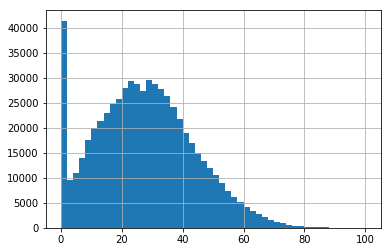

In [27]:
# Plot histogram for track popularity
df['track_popularity'].hist(bins=50)
plt.show()

In [28]:
# Remove the songs with low popularity
df = df[df['track_popularity'] > 0]

In [29]:
df.shape

(578104, 27)

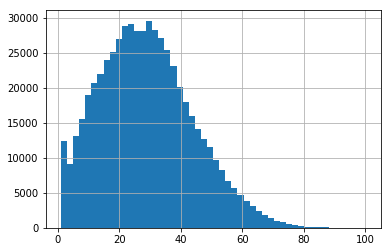

In [30]:
# Plot histogram for track popularity
df['track_popularity'].hist(bins=50)
plt.show()

## Manual one-hot encoding for genre

In [31]:
# Extract all genres from the dataset
genre_list = sorted(set([item for x in df['genre'] for item in x]))
genre_data = df['genre'].apply(lambda row: [1 if x in row else 0 for x in genre_list]).tolist()
genre_df = pd.DataFrame(genre_data, columns=genre_list)

In [32]:
df = df.merge(genre_df, on=df.index)

In [33]:
df.shape

(578104, 119)

In [34]:
# Remove unimportant variables for analysis
var_to_drop = ['key_0', 'artists_id', 'album_id', 'album_id', 
               'track_name', 'artists_name', 'album_name', 
               'release_date_precision', 'genre']
df = df.drop(columns=var_to_drop)

In [35]:
df.shape

(578104, 111)

In [36]:
df.head()

,track_id,album_type,release_date,is_explicit,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_follower,song_age,acoustic,afrobeat,alternative,ambient,anime,black-metal,bluegrass,blues,british,cantopop,chicago-house,chill,classical,comedy,country,dance,dancehall,death-metal,deep-house,detroit-techno,disco,drum-and-bass,dub,dubstep,edm,electro,electronic,emo,folk,forro,french,funk,garage,german,gospel,groove,grunge,guitar,happy,hard-rock,hardcore,hardstyle,hip-hop,house,idm,indian,indie,indie-pop,industrial,j-idol,j-pop,j-rock,jazz,k-pop,latin,mandopop,metal,metalcore,minimal-techno,mpb,new-age,opera,pagode,piano,pop,power-pop,progressive-house,psych-rock,punk,punk-rock,reggae,reggaeton,rock,rockabilly,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,spanish,swedish,tango,techno,trance,trip-hop,turkish,world-music
0,1EzrEOXmMH3G43AXT1y7pA,album,2008-05-12,False,85,0.686,0.457,11,-8.322,1,0.0468,0.595,0.0,0.1050,0.718,150.953,242187,4,4174839,3959.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5vjLSffimiIP26QG5WcN2K,single,2017-02-03,False,77,0.608,0.445,2,-9.551,1,0.0550,0.497,0.0,0.0802,0.189,119.886,198853,4,9693,770.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0IktbUcnAGrvD03AWnz3Q8,album,2008-05-12,False,80,0.623,0.417,0,-8.699,1,0.0354,0.296,0.0,0.1350,0.721,130.032,191360,4,4174839,3959.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53QF56cjZA9RTuuMZDrSA6,album,2012-04-13,False,72,0.585,0.303,4,-10.058,1,0.0398,0.694,0.0,0.1150,0.142,136.703,240166,3,4174839,2527.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38YgZVHPWOWsKrsCXz6JyP,album,2007-01-01,False,72,0.672,0.623,9,-5.699,1,0.0297,0.241,0.0,0.0848,0.617,92.018,215173,4,235394,4456.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
df.to_csv('spotify_data.csv', index=False)